# Exploring and Processing

This notebook gives some examples that use the processed logs from the first notebook run to see the most common questions asked and terms. You can compare the output to dialog and make sure you are covering the proper questions and terms.

The main idea is to reduce the number of words (e.g. "running" and "runs" become "run") and convert to lower case to standardize each word or phrase. Then run analysis.

### Import the libraries

In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import OrderedDict
from IPython.display import Markdown as md
import re
import ast

### Set the Cloud Object Storage Credentials

Download the logs generated from "1. Measure Watson Assistant Performance" for analysis.

In [1]:
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.

# These are dummy values for example.

credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-aaa',
    'IBM_API_KEY_ID': 'apikeyapikeyapikeyapikeyapikeyapikeyapikey',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'watsonassistantaugmentedanalytics-donotdelete-pr-asdfasdfasdfasdf'
}

### Define the log download function

In [9]:
#Define a function that will download the log file from Cloud Object storage

from ibm_botocore.client import Config
import ibm_boto3

def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

### Download the file

In [10]:
download_file_cos(credentials,'annotation.xlsx','All.xlsx')
annotation_file = 'annotation.xlsx'

File Downloaded


### Specify the column names from the downloaded excel file

You shouldn't have to do any modification to this. Notice at the end of this cell, there is a "covered" and "non-covered" section. You could combine both if desired. Not_Covered was chosen for this example.

In [11]:
column_list = [
    '',
    'log_id',
    'conversation_id',
    'timestamp',
    'customer_id',
    'utterance_text',
    'response_text',
    'top_intent',
    'top_confidence',
    'intent_2',
    'intent_2_confidence',
    'confidence_gap',
    'intent_3',
    'intent_3_confidence',
    'entities',
    'is_escalated',
    'is_convered',
    'not_convered_cause',
    'dialog_flow',
    'dialog_stack',
    'dialog_request_counter',
    'dialog_turn_counter',
    'correctness',
    'helpfulness',
    'root_cause',
    'correct_intent',
    'new_intent',
    'add_train',
    'missed_entity',
    'new_entity',
    'new_entity_value',
    'new_dialog_logic',
    'wrong_dialog_node',
    'no_dialog_node_triggered'
]

#Options are :
#Covered
#Not_Covered

annotated_data = pd.read_excel(annotation_file, sheet_name='Not_Covered', names=column_list)

### Convert to Lowercase

In [13]:
annotated_data['utterance_text'] = annotated_data['utterance_text'].apply(lambda x: " ".join(x.lower()for x in x.split()))

In [14]:
annotated_data['utterance_text']

0         how do i start the process for child support?
1     where can we complete the acknowledgment of pa...
2                                 what's child support?
3     i'm about to get a divorce. how do i determine...
4                             what determines paternity
5                                            11/05/1982
6                                            11/05/1982
7     can a private child support collection agency ...
8                            what can you help me with?
9                               what license suspension
10                    how can child support be changed?
11                                         i need a cin
12                            what determines paternity
13    what information does the office of the attorn...
14                         who is the attorney general?
15                                           11/05/1982
Name: utterance_text, dtype: object

### Stemming

Extracting a Root word, e.g. fly, flys and flying are stemmed to fly. We use lematizing below, but this can be used if desired. It is put in here as an example.

In [15]:
from nltk.stem import PorterStemmer

In [16]:
st = PorterStemmer()

In [17]:
annotated_data_stem = annotated_data['utterance_text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [18]:
annotated_data_stem.head(5)

0        how do i start the process for child support?
1    where can we complet the acknowledg of patern ...
2                                 what' child support?
3    i'm about to get a divorce. how do i determin ...
4                                 what determin patern
Name: utterance_text, dtype: object

### Lemmatizing

Handles matching “car” to “cars” along with matching “car” to “automobile.”

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .

In [19]:
#When you don't have a library
!pip install textblob

     |████████████████████████████████| 645kB 2.2MB/s eta 0:00:01


In [20]:
#Import library
from textblob import Word

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [21]:
annotated_data_lem = annotated_data['utterance_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [22]:
annotated_data_lem.head(5)

0        how do i start the process for child support?
1    where can we complete the acknowledgment of pa...
2                                what's child support?
3    i'm about to get a divorce. how do i determine...
4                            what determines paternity
Name: utterance_text, dtype: object

### Explore the Data

In [23]:
#nltk.download()
#Importing data
import nltk
from nltk.corpus import webtext
#nltk.download('webtext')
#wt_sentences = webtext.sents('firefox.txt')
#wt_words = webtext.words('firefox.txt')

In [24]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string

In [25]:
frequency_dist_sent = nltk.FreqDist(annotated_data_lem)
frequency_dist_sent

FreqDist({'11/05/1982': 3, 'what determines paternity': 2, 'how do i start the process for child support?': 1, 'where can we complete the acknowledgment of paternity form?': 1, "what's child support?": 1, "i'm about to get a divorce. how do i determine what i need to pay for child support?": 1, 'can a private child support collection agency process my case faster?': 1, 'what can you help me with?': 1, 'what license suspension': 1, 'how can child support be changed?': 1, ...})

In [26]:
df_annotated_data_lem = pd.DataFrame(data=annotated_data_lem)

In [27]:
#DEBUG: View the Data
df_annotated_data_lem.head(4)

,utterance_text
0,how do i start the process for child support?
1,where can we complete the acknowledgment of pa...
2,what's child support?
3,i'm about to get a divorce. how do i determine...


In [28]:
words = ' '.join(df_annotated_data_lem['utterance_text'].tolist())
#DEBUG:
#words

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
frequency_dist = nltk.FreqDist(nltk.word_tokenize(words))
frequency_dist

FreqDist({'?': 9, 'what': 7, 'i': 5, 'the': 5, 'child': 5, 'support': 5, 'can': 4, 'a': 4, 'how': 3, 'paternity': 3, ...})

In [31]:
sorted_frequency_dist =sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)

In [3]:
# DEBUG : View the most common words
#sorted_frequency_dist

In [33]:
#Take out the small words, anything less than 4 characters

large_words = dict([(k,v) for k,v in frequency_dist.items() if
len(k)>4])

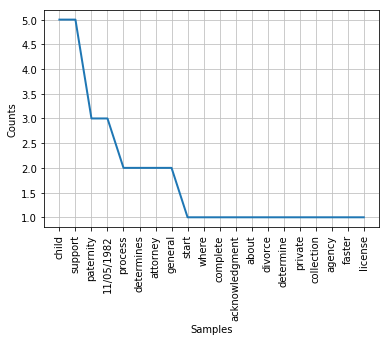

In [35]:
frequency_dist = nltk.FreqDist(large_words)
frequency_dist.plot(20,cumulative=False)

In [35]:
#Build a WordCloud

In [36]:
#install library
!pip install wordcloud

     |████████████████████████████████| 368kB 1.8MB/s eta 0:00:01


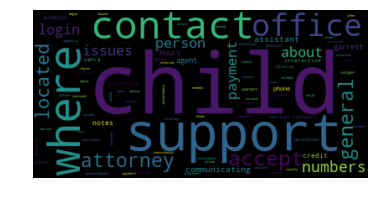

In [37]:
#build wordcloud
from wordcloud import WordCloud
wcloud = WordCloud().generate_from_frequencies(frequency_dist)
#plotting the wordcloud
import matplotlib.pyplot as plt
plt.imshow(wcloud, interpolation='bilinear')
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

In [38]:
frequency_dist_sent

FreqDist({'where are you located?': 10, 'contact numbers?': 8, 'i have some child support issues, but i am deaf. how do i go about communicating with the attorney general’s office?': 7, 'garrett': 6, 'what are your hours?': 6, "i can't login to csi": 5, 'need help': 5, 'do you accept bank notes?': 5, 'where are you?': 4, 'can i pay with credit card?': 4, ...})

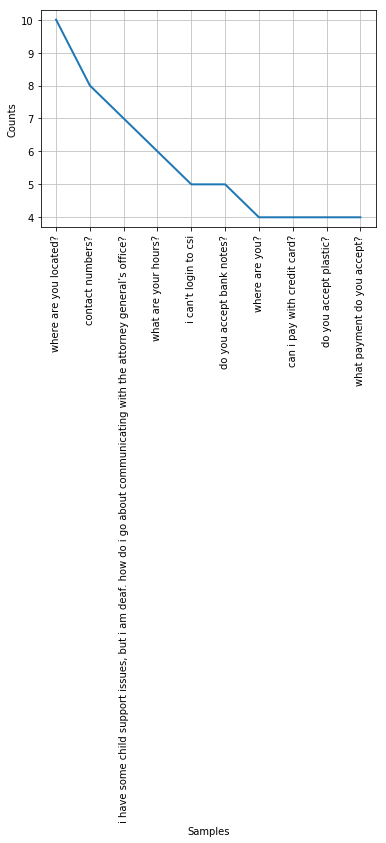

In [39]:
large_words = dict([(k,v) for k,v in frequency_dist_sent.items() if len(k)>10] )
frequency_dist_sent = nltk.FreqDist(large_words)
frequency_dist_sent.plot(10,cumulative=False)
